# Analytical Helmholtz

Brendan Smithyman | October, 2015

This notebook implements a very simple class to model the whole-space point-source response of the 2D or 3D Helmholtz equation. We compare the different responses produced when using either $H_0^{(1)}$ (i.e., the Hankel function of the zeroth order of the first kind) or $H_0^{(2)}$ (the Hankel function of the zeroth order of the second kind). These are complex conjugates of each other, and so one of the resulting wavefields is the time-reversed response (after a sign flip).

## Plotting Setup

The following block contains setup for plotting defaults. Note that we change the font to 'Fira Sans Book'. If you don't have this font on your system, you could comment out the last few lines, or replace it with a font that you prefer to use.

In [1]:
# Plotting imports and defaults

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
matplotlib.rcParams['savefig.dpi'] = 300

# Font options
font = {
    'family': 'Bitstream Vera Sans',
    'weight': 'normal',
    'size': 8,
}

matplotlib.rc('font', **font)

## Imports

Here, we import the necessary libraries to do the computations: `numpy`, which is the main scientific & numerical computing library in Python, and the `hankel1` and `hankel2` functions from `scipy.special`.

In [2]:
import numpy as np
from scipy.special import hankel1, hankel2

## Class Definition

Here, we build a class called `AnalyticalHelmholtz`, which inherits from `object`.

The `__init__` method is called automatically when we *instantiate* the class (i.e., make a new object based on `AnalyticalHelmholtz`). The `__init__` method expects one or two inputs: 1) a required input (dictionary) called `sc`, which contains the configuration for the system, and 2) an optional input called `hf`, which defaults to the `hankel` function from `scipy.special`.

When running `__init__`, Python first stores some properties from the `sc` parameter, and determines whether it is going to run in 2D mode or 3D mode. At the end of this method, a member object `_hf` is created, which stores a reference to the chosen Hankel function (from `hf`).

When an object of class `AnalyticalHelmholtz` is called like a function, Python executes the `__call__` method. This uses whichever Green's function was set up during `__init__`, and returns a wavefield. The distance from the source is calculated for each point in the grid (from the $x$ and $z$ locations passed into the function call), and the response is returned as a `numpy` array (based on the configuration in the `sc` object from when the `AnalyticalHelmholtz` class was instantiated).

NB: `k` is a property, which behaves like a variable bound to the instance, but actually runs some code inside the `k` method when its value is asked for. This way, it can be calculated and stored based on the `omega` and `c` properties.

In [3]:
class AnalyticalHelmholtz(object):
    '''
    Implements the analytical Green's functions for the 2D and 3D
    Helmholtz equation(s).
    ''' 

    def __init__(self, sc, hf = hankel1):

        self.dimension = sc.get('dimension', 2)
        self.omega = sc['omega']
        self.c = sc['c']

        if self.dimension == 3:
            self.Green = self.Green3D
        else:
            self.Green = self.Green2D

        self._x, self._z = np.mgrid[
            sc['xorig']:sc['xorig']+sc['dx']*sc['nx']:sc['dx'],
            sc['zorig']:sc['zorig']+sc['dz']*sc['nz']:sc['dz']
        ]
        
        self._hf = hf

    def Green2D(self, x):

        return -0.5j * self._hf(0, self.k*x)

    def Green3D(self, x):

        return (1./(4*np.pi*x)) * np.exp(1j*self.k*x)

    def __call__(self, x, z):

        return np.nan_to_num(self.Green(np.sqrt((x - self._x)**2 + (z - self._z)**2)))
    
    @property
    def k(self):
        if getattr(self, '_k', None) is None:
            self._k = self.omega / self.c
        return self._k

## Object Instantiation

The following cell contains the `systemConfig` dictionary, which we build up from a series of keys and values. I make fairly liberal use of *whitespace* here to keep the values nicely-organized. By changing these values, you can change the behaviour of the `AnalyticalHelmholtz` objects that use this configuration.

There are two `AnalyticalHelmholtz` objects created here. Note that they are roughly the same (they use the same `systemConfig` object), except that one of them uses the `hankel1` function $H_0^{(1)}$ and the other uses the `hankel2` function $H_0^{(2)}$. At this point, the `__init__` methods have been called for both objects, but no wavefields have been constructed. However, the `AnalyticalHelmholtz` objects know *how* to generate wavefields when asked.

In [4]:
systemConfig = {
    'c':            2000.,
    'omega':        200.,
    'dimension':    2,
    'nx':           100,
    'nz':           200,
    'dx':           1.,
    'dz':           1.,
    'xorig':        0.,
    'zorig':        0.,
}

ah1 = AnalyticalHelmholtz(systemConfig, hankel1)
ah2 = AnalyticalHelmholtz(systemConfig, hankel2)

## Wavefield Modelling

Here, we set two variables (`xs` and `zs`), which contain the coordinates for the source. Then, we produce two wavefields: `u1`, which uses our `ah1` object and `u2`, which uses our `ah2` object. These wavefields are `numpy` arrays, with dimensions and shapes dependent on the `systemConfig` we used.

In [5]:
xs = 15.
zs = 15.

u1 = ah1(xs, zs)
u2 = ah2(xs, zs)

## Plotting

We create a `dict` called `plotopts`, which contains a number of default settings for the `imshow` function. We then use the `matplotlib` object-oriented interface to build up a figure. We have 4 subplots, each of which includes a call to `plt.imshow` to plot the appropriate wavefield, and a call to `plt.title` to label it.

NB: The call to `fig.tight_layout` rearranges the plots so that their axis labels are not overlapping.

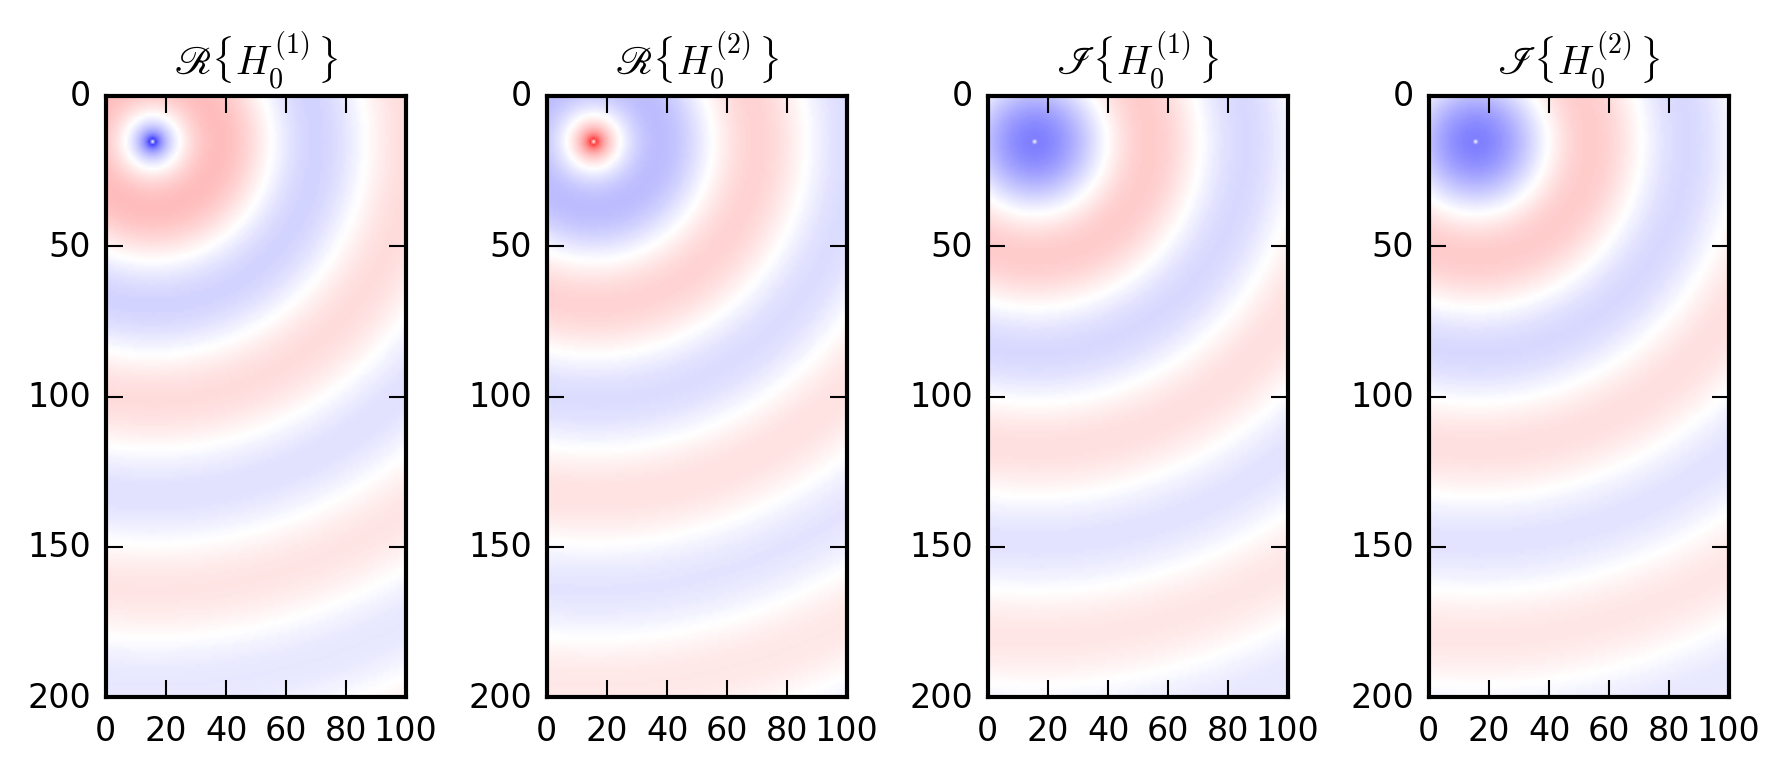

In [6]:
plotopts = {
    'cmap':     cm.bwr,
    'vmin':     -1.,
    'vmax':     1.,
    'extent':   [
        systemConfig['xorig'],
        systemConfig['xorig'] + systemConfig['dx'] * systemConfig['nx'],
        systemConfig['zorig'] + systemConfig['dz'] * systemConfig['nz'],
        systemConfig['zorig'],
    ],
}

fig = plt.figure()

ax = fig.add_subplot(1,4,1, aspect=1)
plt.imshow(u1.real.T, **plotopts)
plt.title('$\mathscr{R}\{ H_0^{(1)} \}$')

ax = fig.add_subplot(1,4,2, aspect=1)
plt.imshow(u2.real.T, **plotopts)
plt.title('$\mathscr{R}\{ H_0^{(2)} \}$')

ax = fig.add_subplot(1,4,3, aspect=1)
plt.imshow(u1.imag.T, **plotopts)
plt.title('$\mathscr{I}\{ H_0^{(1)} \}$')

ax = fig.add_subplot(1,4,4, aspect=1)
plt.imshow(u2.imag.T, **plotopts)
plt.title('$\mathscr{I}\{ H_0^{(2)} \}$')

fig.tight_layout()

## Exercises

1. Modify the `AnalyticalHelmholtz` class to take the source location as a `tuple`, rather than as two separate numbers; i.e., $(xs, zs)$.
2. Modify the `AnalyticalHelmholtz` class to simulate a free-surface response at the top of the model. To do this, you will need to add a second *ghost source*, with the same $x$-position as the main source, but with a $z$-position reflected around the top of the model (and the opposite sign).
3. Add a *property* to the `AnalyticalHelmholtz` class that returns the `extent` to use for plotting purposes (i.e., that tells the plotting code what the boundaries of the model are).
4. Add appropriate labels to the $x$- and $z$-axes of the plots.